In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np
import functools

# Second-Order Optimization

Let's discuss optimization in the context of **second-order gradient descent**. The idea here is to use second-order gradient information in combination with first-order information to make more accurate update steps. The basic algorithm is also known as **Newton's method**. Examining the difference between first and second-order gradient updates:

$$
\begin{align}
\theta & \leftarrow \theta - \alpha \nabla_\theta \; L(\theta)  & & \text{(First-order gradient descent)}\\
\theta & \leftarrow \theta - \alpha H(\theta)^{-1} \nabla_\theta \; L(\theta)  & & \text{(Second-order gradient descent)}\\
\end{align}
$$

is the presence of the $H(\theta)^{-1}$ term. This is a matrix so important we give it a name, the **Hessian**, and it is the matrix of all pairwise second-order derivatives of $L(\theta)$. By scaling our gradients with the inverse Hessian, we get a number of nice properties (which we will examine shortly). The downside of course is the cost; calculating $H(\theta)$ itself is expensive, and inverting it even more so.

In the rest of this page, we'll look at:
- Interpretations of second-order descent
- Approximations to computing $H(\theta)^{-1}$ in classical optimization
- Approximations to computing $H(\theta)^{-1}$ in deep learning

## Second-order descent as preconditioning

A black-box way to view second-order descent is as a specific type of **preconditioning**. Recall that a preconditioner is a linear transformation of the gradient, often written as a matrix:

$$
\theta \leftarrow \theta - P \; \nabla_\theta \, L(\theta).
$$

We often want to use preconditioning when we want to update certain parameters at different speeds. For example, a diagonal preconditioner can be used to specify per-parameter learning rates. In classical optimization problems, this can be helpful is we know that e.g. certain inputs have a much higher magnitude, etc. The inverse Hessian ends up being the 'correct' way to precondition a gradient update using second-order information, as shown next.

## Second-order descent as solving a quadratic approximation

We can approximate the true loss function using a second-order Taylor series expansion:

$$
\tilde{L}(\theta + \theta') = L(\theta) + \nabla L(\theta)^{T}\theta' + \dfrac{1}{2} \theta'^{T} \nabla^2 L(\theta) \theta'.
$$

Assuming $\nabla^2 L(\theta)$ is invertible, we can now solve for the $\theta'$ that minimizes this approximate loss:

$$
\begin{align}
& \nabla \tilde{L}(\theta + \theta') = 0 \\
& \nabla L(\theta) + \nabla^2 L(\theta) \theta' = 0 \\
& \theta' = (\nabla^2 L(\theta))^{-1} \nabla L(\theta) \\
& \theta' = H(\theta)^{-1} \nabla L(\theta) \\
\end{align}
$$

which gives us our original second-order descent method. So, the (unscaled) second-order descent iteration is the same as jumping directly to a point that minimizes the quadratic approximation of the loss function. In practice, we often still take a smaller step to account for approximation errors.

## Second-order descent as knowing how far to step

A key property of the Hessian of *convex functions* is that it is positive definite -- in other words, matrix multiplying will never flip the sign of a vector. Even for non-convex functions, we can apply regularization such that the Hessian always remains positive definite. So, second-order descent is **sign preserving** and will update each parameter in the same direction as first-order descent. The difference is in how *much* the parameter is updated. 


## Example: 2D Classical Optimization

Let's examine how various second-order methods work on a simple 2D optimization problem. We'll use a fourth-order polynomial loss function, which is convex but not as simple as a quadratic. As a sanity check, gradient descent can find the minimum within 15 iterations or so:

In [16]:
def loss_fn(z):
    x, y = z
    y = y * 2
    x = x * 0.8 - 0.5
    x_polynomials = jnp.array([x ** (i+1) for i in range(4)])
    y_polynomials = jnp.array([y ** (i+1) for i in range(4)])
    all_polynomials = jnp.concatenate([x_polynomials, y_polynomials])
    multipliers = jax.random.uniform(jax.random.PRNGKey(1), (8,))
    multipliers = multipliers.at[3].set(1)
    multipliers = multipliers.at[7].set(1)
    return jnp.dot(all_polynomials, multipliers)

def plot_optim(optim_fn, opt_state, steps=15):
    iter_points = []
    z = jnp.array([-0.9, 0.4])
    for i in range(steps):
        iter_points.append(z)
        z, opt_state = optim_fn(z, opt_state, loss_fn)

    # Create a grid of points
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-0.5, 0.5, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.stack([X.flatten(), Y.flatten()], axis=-1)
    Z = jax.vmap(loss_fn)(XY)
    Z = Z.reshape(X.shape)

    # Create the plot
    plt.figure(figsize=(6, 3))
    contour = plt.contour(X, Y, Z, levels=30, cmap='viridis', alpha=0.4)
    plt.clabel(contour, inline=True, fontsize=8)

    iter_points = np.array(iter_points)
    plt.plot(iter_points[:, 0], iter_points[:, 1], 'ro-')
    plt.xticks([])
    plt.yticks([])
    plt.show()

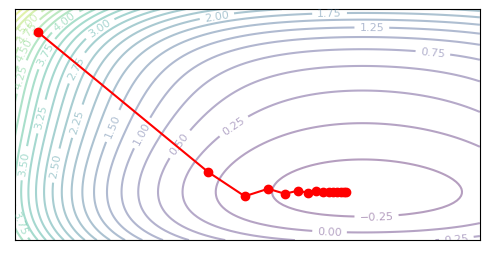

In [4]:
@functools.partial(jax.jit, static_argnums=(2,))
def gradient_descent(z, opt_state, loss_fn):
    grad_z = jax.grad(loss_fn)(z)
    new_z = z - 0.1 * grad_z
    opt_state = None
    return new_z, opt_state
plot_optim(gradient_descent, None)

Note how learning slows down near the minimum, as the absolute scale of the gradient also approaches zero. Second-order methods provide a way to correct for this.

## Newton's Method

Now, we'll implement an iterative version of Newton's method. Remember that Newton's method is equivalent to finding the solutions to a quadratic approximation of the loss. If the true loss is quadratic, we can solve the problem in a single step. Our loss is not quadratic (it's a fourth-order polynomial), so we need to use an *iterative* version of Newton's method, with a smaller step size.

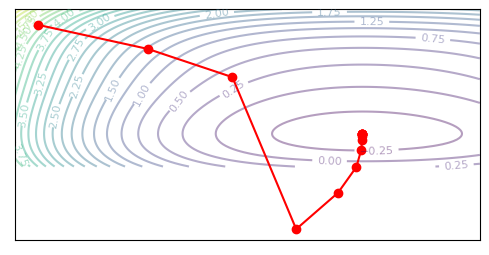

In [5]:
@functools.partial(jax.jit, static_argnums=(2,))
def newton_descent(z, opt_state, loss_fn):
    grad_z = jax.grad(loss_fn)(z)
    hessian_z = jax.hessian(loss_fn)(z)
    new_z = z - 0.8 * (jnp.linalg.inv(hessian_z) @ grad_z)
    opt_state = None
    return new_z, opt_state
plot_optim(newton_descent, None)

Cool, we learn pretty fast, but we also end up overshooting the optimal parameters. The danger of Newton's method is that we can end up taking larger steps than we mean to, since our Hessian is only locally accurate.

## Regularized Newton

An intuitive way to look at Newton's method is that by scaling our gradient by the inverse Hessian, we can take larger steps in flatter directions, since those steps should have a smaller overall effect. The problem any errors in the Hessian have the potential to drastically overstep.

One way to regularize the Newton update is to **dampen** the update and penalize movement in flatter directions. We can do this by adding an identity matrix to the Hessian. This addition is similar to enforcing a maximum flatness -- even if the Hessian estimates a direction as extremely flat, we will treat it as somewhat sloped to prevent excessive updates.

The regular Newton and the dampened Newton behave similarly at high curvature, but at lower curvature, the dampened Newton will behave more conseratively. This lets us safely increase our learning rate.

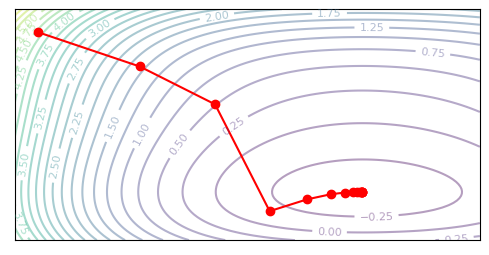

In [6]:
@functools.partial(jax.jit, static_argnums=(2,))
def damped_newton_descent(z, opt_state, loss_fn):
    grad_z = jax.grad(loss_fn)(z)
    hessian_z = jax.hessian(loss_fn)(z)
    new_z = z - 0.8 * (jnp.linalg.inv(hessian_z + jnp.eye(2) * 1) @ grad_z)
    opt_state = None
    return new_z, opt_state
plot_optim(damped_newton_descent, None)

## Trust Region Newton

As we saw above, a pain point with Newton methods is that the Hessian is not always well-behaved. If the diagonal values are too small, we can run into numerical issues, and a non-positive-definite Hessian can even cause us to move in a direction that *increases* loss. A more stable way to use second-order information is to view second-order information as enforcing a **trust region** over first-order descent. We will minimize first-order loss, subject to a constraint that on the change in parameters.

$$
\Delta \theta = \text{argmin}_{\Delta \theta} \tilde{L}(\theta + \Delta \theta) \qquad \text{st.} \qquad d(\theta, \theta + \Delta \theta) < \Delta
$$

Note that $\tilde{L}$ is the first-order approximation of $L$. As a linear function, the argmin of this approximation lies at infinity, so we need an appropriate constraint to have a viable algorithm. In naive gradient descent, we simply use a small learning rate to approximate a trust region.

Let's define a better trust region. We know that the Hessian represents second-order behavior of a change in parameters, so we can use the Hessian to define a notion of distance. To make things easier, we can use the **absolute value eigenvalue form** $|H|$, which upper bounds the normal $H$.
```{margin}
For any $H$, $|x^T H x| < x^T |H| x$, where $|H|$ is the result of decomposing $H$ into its eigenbasis, then taking the absolute value of each eigenvalue and reconstructing $H$.
```

$$
d(\theta, \theta + \Delta \theta) = \Delta \theta^T |H| \Delta \theta < \Delta
$$

In fact, the solution to the constrained problem above is the same as Newton's method, but we use the absolute value eigenvalue form of H, which is always positive-definite. Intuitively, we use the magnitude of the second-order behavior, but enforce that the sign of the gradient remains the same. 

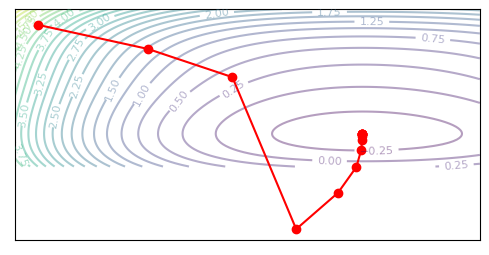

In [7]:
@functools.partial(jax.jit, static_argnums=(2,))
def trust_region_newton(z, opt_state, loss_fn):
    grad_z = jax.grad(loss_fn)(z)
    hessian_z = jax.hessian(loss_fn)(z)
    eigvals, eigvecs = jnp.linalg.eig(hessian_z)
    eigvals = jnp.abs(eigvals)
    hessian_psd = jnp.dot(eigvecs, jnp.dot(jnp.diag(eigvals), eigvecs.T)).real
    new_z = z - 0.8 * (jnp.linalg.inv(hessian_psd) @ grad_z)
    opt_state = None
    return new_z, opt_state
plot_optim(trust_region_newton, None)

**Null result**. In our 2D example here, the trust region and Newton method are actually just the same, since $H$ is always positive-definite along our optimizaztion path. The existence of saddle points scales with dimensionality, and in a 2D example they are rare or nonexistent. In high-dimensional problems, the trust region approach may provide a benefit. An important result is that in the toy case, the trust region approach *does not harm* learning, thus the absolute-value approximation is reasonable.

## BFGS

Now, we will examine a class of methods known as **quasi-Newton** methods, which do not construct the exact Hessian but rather an approximation of it. The main idea in BFGS is to use finite difference methods to approximate the Hessian. We're already taking first-order gradients, and by viewing the resulting affect on the loss of applying these gradients, we can get an estimate of the second-order behavior.
```{margin}
BFGS is named for Broyden, Fletcher, Goldfarb, and Shanno, the independent creators of the algorithm.
```

Let's start with a simple relation. We want to find a matrix $\tilde{H}$ that approximates the true Hessian $H$. We know that such a matrix should satisfy the **finite-difference relation**:

$$
\tilde{H} \Delta \theta = \nabla L(\theta + \Delta \theta) - \nabla L(\theta) \qquad \text{or} \qquad \tilde{H} \Delta \theta = \Delta g
$$

where $g = \nabla L(\theta)$ represents gradients. The equation states that under any change $\Delta \theta$, the matrix $\tilde{H}$ should accurately represent the corresponding change in *gradients*. The true Hessian satisfies this condition by definition.

Now, we will find a strategy to discover $\tilde{H}$ in an iterative manner. We want $\tilde{H}$ to always be symmetric and positive-definite -- as we saw in the previous sections, this makes for a well-behaved distance. Let's go over a simple iteration. When we take a gradient step, we can evaluate the gradient before and after the parameter change, giving us the $\Delta \theta$ and $\Delta g$ terms above. So, we should update our estimate $\tilde{H}$ to solve this new equation. There are many possible $\tilde{H}$ which solve the system, but we can add a constraint that the change in $\tilde{H}$ is rank 1.

This gives us the **Broyden formula**. We want to find $v$ such that $\tilde{H} + vv^T$ satisfies the finite-difference relation. Solving it out:

$$
\begin{align}
    & \tilde{H}' = \tilde{H} + vv^T \qquad \text{st.} \qquad (\tilde{H} + vv^T) \Delta \theta = \tilde{H} \Delta \theta + vv^T \Delta \theta = \Delta g \\
    & \tilde{H}' = \tilde{H} + \frac{(\tilde{H} \Delta \theta - \Delta g)(\tilde{H} \Delta \theta - \Delta g)^T}{(\tilde{H} \Delta \theta - \Delta g)^T \Delta \theta} 
\end{align}
$$ 

which gives the corresponding rank-1 update to $\tilde{H}$. The problem this this approach is that we do not have a guarantee that $\tilde{H}$ remains positive definite.

The **BFGS formula** gives a rank-2 update that retains positive definiteness:

$$
\begin{align}
    & \tilde{H}' = \tilde{H} + \frac{(\Delta g)(\Delta g)^T}{(\Delta g)^T(\Delta \theta)} - \frac{\tilde{H} (\Delta \theta) (\Delta \theta)^T \tilde{H}}{(\Delta \theta)^T \tilde{H} (\Delta \theta)}
\end{align}
$$ 

[-0.9  0.4] [-7.30973    6.0483007] [ 1.0964595  -0.90724516]
[ 0.19645953 -0.5072452 ] [-0.4776855 -6.7761297] [0.50995517 0.33745077]
[ 0.7064147  -0.16979441] [0.26373705 1.2974032 ] [-0.02001303 -0.00879509]
[ 0.68640167 -0.17858951] [0.2383132 1.2436786] [-0.04294504 -0.02353329]
[ 0.64345664 -0.2021228 ] [0.18472485 1.0735395 ] [-0.03063481 -0.01961849]
[ 0.6128218  -0.22174127] [0.14695834 0.8995274 ] [-0.0209615  -0.01454363]
[ 0.5918603 -0.2362849] [0.12117057 0.7498102 ] [-0.01531359 -0.01083261]
[ 0.5765467 -0.2471175] [0.10229781 0.62604105] [-0.01198131 -0.00829052]
[ 0.5645654  -0.25540802] [0.08748624 0.52390766] [-0.00982943 -0.00649308]
[ 0.554736  -0.2619011] [0.07529204 0.43927383] [-0.00829801 -0.00517122]
[ 0.546438   -0.26707232] [0.06496011 0.36887503] [-0.00711636 -0.00416854]
[ 0.5393216  -0.27124086] [0.05606759 0.31015372] [-0.00615007 -0.00339048]
[ 0.53317153 -0.27463135] [0.04835599 0.26107335] [-0.00533036 -0.00277663]
[ 0.52784115 -0.27740797] [0.0416503

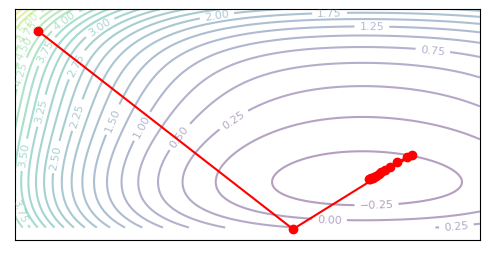

In [51]:
# @functools.partial(jax.jit, static_argnums=(2,))
def bfgs(z, opt_state, loss_fn):
    H = opt_state
    grad_z = jax.grad(loss_fn)(z)
    # Real BFGS should search for the optimal step size, but we'll just use a fixed one
    dz = -0.15 * (jnp.linalg.inv(H) @ grad_z)
    new_z = z + dz
    grad_newz = jax.grad(loss_fn)(new_z)
    dg = grad_newz - grad_z
    H_new = H + (jnp.outer(dg, dg) / jnp.dot(dg, dz)) \
              - (jnp.outer(jnp.dot(H, dz), jnp.dot(H, dz)) / jnp.dot(dz, jnp.dot(H, dz)))
    print(z, grad_z, dz)
    return new_z, H_new
plot_optim(bfgs, jnp.eye(2))

The **L-BFGS (Limited-memory BFGS) formula** lets us save memory on our Hessian estiamte. In the BFGS algorithm above, we store the entire $\tilde{H}$ matrix, and invert it at every iteration. Both of these are expensive criteria that we would perfer to remove. Instead, let's see if we can get away with only storing a low-rank approximation of the *inverse* Hessian directly.

The idea in L-BFGS is to keep the last $M$ parameter-gradient pairs in memory, and use them to iteratively update our current gradient to mimic the effect of multiplying by the inverse Hessian. This is commonly achieves using the **two-loop recursion** approach, which first constructs scalars $a_i$ and a vector $q$, then uses them to construct the final update $H^{-1} g$.

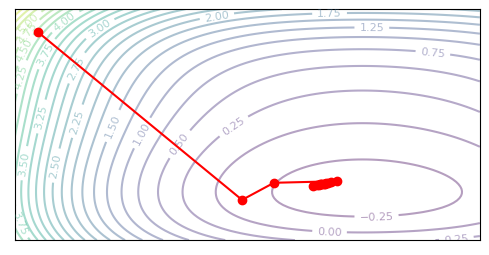

In [67]:
def lbfgs(z, opt_state, loss_fn):
    dzs, dgs = opt_state
    grad_z = jax.grad(loss_fn)(z)
    grad_z_raw = grad_z

    # Compute H^-1 grad_z via L-BFGS approximation.
    alphas = []
    for i in range(len(dzs)):
        alpha = jnp.dot(dzs[i], grad_z) / jnp.dot(dzs[i], dgs[i])
        grad_z = grad_z - alpha * dgs[i]
        alphas.append(alpha)
    Hz = grad_z * 0.15 # Starting guess for (H^-1 grad_z) is a constant scale.
    for i in reversed(range(len(dzs))):
        beta = jnp.dot(dgs[i], Hz) / jnp.dot(dzs[i], dgs[i])
        Hz = Hz + (alphas[i] - beta) * dzs[i]
        
    # Real BFGS should search for the optimal step size, but we'll just use a fixed one
    dz = -0.8 * Hz
    new_z = z + dz
    dg = jax.grad(loss_fn)(new_z) - grad_z

    dzs = [dz] + dzs
    dgs = [dg] + dgs
    return new_z, (dzs, dgs)
plot_optim(lbfgs, ([], []), steps=15)

In the precise form, the BFGS and L-BFGS should use a line search to look for the optimal step size. In our implementation I opted to just use a constant step size instead for simplicity. The methods both seem to work after playing with hyperparameters, but numerical issues seem to arise when near the solution. I found that the approximate Hessian often estimates a high curvature, resulting in the second-order update becoming too small near the end -- see the L-BFGS trajectory which does not converge to the minimum.

## Example: CIFAR-10 Classification

Let's move on to an example training real neural networks. Continuing from previous pages, we'll train a small vision transformer to classify CIFAR-10. We will first run a baseline with standard gradient descent.

- First-Order SGD
- Second-Order (slow)
- Gauss-Newton
- Natural Gradient
- KFAC
- Shampoo
- Adam as ...

In [71]:
from einops import rearrange

from keras.datasets import cifar10
(train_images, train_labels), (valid_images, valid_labels) = cifar10.load_data()

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = jnp.arange(embed_dim // 2, dtype=jnp.float32) / (embed_dim // 2)
    omega = 1. / 10000**omega  # (D/2,)
    pos = pos.reshape(-1)  # (M,)
    out = jnp.einsum('m,d->md', pos, omega)  # (M, D/2), outer product
    emb = jnp.concatenate([jnp.sin(out), jnp.cos(out)], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, length):
    grid_size = int(length ** 0.5)
    assert grid_size * grid_size == length
    grid_hw = jnp.arange(grid_size, dtype=jnp.float32)
    grid = jnp.stack(jnp.meshgrid(grid_hw, grid_hw), axis=0)
    grid = grid.reshape([2, 1, grid_size, grid_size])
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    pos_embed = jnp.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return jnp.expand_dims(pos_embed, 0) # (1, H*W, D

class TinyViT(nn.Module):
    features: int = 128
    patch_size: int = 8
    num_classes: int = 10
    dropout: float = 0.3

    @nn.compact
    def __call__(self, x, deterministic=False):
        patch_tuple = (self.patch_size, self.patch_size)
        num_patches = (x.shape[1] // self.patch_size)
        x = nn.Conv(self.features, patch_tuple, patch_tuple, use_bias=True, padding="VALID")(x) # Patch Embed
        x = rearrange(x, 'b h w c -> b (h w) c', h=num_patches, w=num_patches)
        x = x + get_2d_sincos_pos_embed(self.features, num_patches**2)
        x = jnp.concatenate([x, nn.Embed(1, self.features)(jnp.zeros((x.shape[0], 1), dtype=jnp.int32))], axis=1) # Class Token
        for _ in range(4):
            y = nn.LayerNorm()(x)
            y = nn.MultiHeadDotProductAttention(num_heads=4, dropout_rate=self.dropout, deterministic=deterministic)(y, y)
            x = x + y
            y = nn.LayerNorm()(x)
            y = nn.Dense(self.features * 2)(y)
            y = nn.gelu(y)
            y = nn.Dropout(rate=self.dropout, deterministic=deterministic)(y)
            y = nn.Dense(self.features)(y)
            y = nn.Dropout(rate=self.dropout, deterministic=deterministic)(y)
            x = x + y
        x = x[:, 0]
        x = nn.Dense(self.num_classes)(x)
        return x

def sample_batch(key, batchsize, images, labels):
    idx = jax.random.randint(key, (batchsize,), 0, images.shape[0])
    return images[idx], labels[idx]

def zero_params(params):
    return jax.tree_map(lambda x: jnp.zeros_like(x), params)

def train_cifar(optimizer_fn, init_opt_fn, max_steps):
    train_losses = []
    classifier = TinyViT()
    key = jax.random.PRNGKey(0)
    key, param_key = jax.random.split(key)
    v_images, v_labels = sample_batch(param_key, 256, valid_images, valid_labels)
    params = classifier.init({'params': param_key, 'dropout': param_key}, v_images)['params']
    opt_state = init_opt_fn(params)

    @jax.jit
    def update_fn(key, params, opt_state, images, labels, step, max_steps):
        def loss_fn(p, x, y):
            x = x / 255.0
            onehot_labels = jax.nn.one_hot(y[:, 0], 10)
            logits = classifier.apply({'params': p}, x, rngs={'dropout': key}, deterministic=False)
            loss = jnp.mean(jnp.sum(-nn.log_softmax(logits) * onehot_labels, axis=-1))
            return loss
        grad_fn = functools.partial(jax.value_and_grad(loss_fn), x=images, y=labels)
        loss, params, opt_state = optimizer_fn(params, opt_state, grad_fn, step, max_steps)
        return loss, params, opt_state
    for i in tqdm.tqdm(range(max_steps)):
        key, data_key, update_key = jax.random.split(key, 3)
        images, labels = sample_batch(data_key, 128, train_images, train_labels)
        loss, params, opt_state = update_fn(update_key, params, opt_state, images, labels, i, max_steps)
        train_losses.append(np.array(loss))
    return np.array(train_losses)

def plot_losses(losses, labels, title, colors=None, ylim=2):
    fig, axs = plt.subplots(1, figsize=(5, 3))
    for i, (label, loss) in enumerate(zip(labels, losses)):
        loss = np.convolve(loss, np.ones(1000), 'valid') / 1000
        axs.plot(loss, label=label, color=colors[i] if colors else None)
    axs.legend()
    axs.set_ylim(-0.05, ylim)
    axs.set_title(title)
    plt.show()

103145472/170498071 [=================>............] - ETA: 11s

KeyboardInterrupt: 

In [69]:
def sgd(params, opt_state, grad_fn):
    loss, grads = grad_fn(params)
    lr = 0.001
    new_params = jax.tree_map(lambda p, u: p - lr * u, params, grads)
    return loss, new_params, None
init_opt_fn = lambda p : None

constant_loss = train_cifar(sgd, init_opt_fn, 20_000)

NameError: name 'valid_images' is not defined

#### References

https://www.lix.polytechnique.fr/bigdata/mathbigdata/wp-content/uploads/2014/09/notes_quasi_newton.pdf

https://www.deeplearningbook.org/contents/optimization.html

http://www.athenasc.com/nonlinbook.html

